# Predicting Change in Credit Score - A Comprehensive Solution

### By: [Your Name Here]

---

### Objective

This notebook presents an end-to-end solution to the internship problem statement. The goal is to simulate a realistic dataset and build a high-performance machine learning model to predict whether a customer's credit score will `increase`, `decrease`, or `remain stable` in the next 3 months.

### Our Approach: A Strategy for Excellence

To create a solution that is not just accurate but also robust and insightful, we will follow a professional, multi-stage approach:

1.  **Causally-Driven Data Generation:** Instead of generating purely random data, we will simulate a world where a customer's underlying (hidden) archetype drives their behavior. This creates a strong, learnable relationship between a customer's history and their future outcome, which is key to building a high-performance model.

2.  **Point-in-Time Feature Engineering:** To prevent data leakage—a critical error in time-series problems—we will engineer features for prediction using *only* data from a customer's history up to a specific cutoff point. This mimics a real-world scenario where we predict the future using only the past.

3.  **Advanced Hyperparameter Optimization:** We will use `Optuna`, a state-of-the-art framework, to systematically find the best possible settings for our model, ensuring maximum performance.

4.  **In-Depth Analysis & Actionable Insights:** We will not only evaluate the model's accuracy but also use `SHAP` to understand *why* it makes its predictions. This allows us to answer the bonus question by proposing specific, data-driven product and policy interventions.

## Part 1: Setup & Environment

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import joblib
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Set a consistent style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Part 2: The Foundation - Causal Data Generation

A model is only as good as its data. Instead of generating features and a target independently, we'll create a more realistic simulation. We'll define customer **archetypes** (e.g., `improving`, `worsening`). This hidden archetype will dictate both the customer's historical behavior (their trends in credit utilization and repayment) and their final target outcome. This establishes a strong **causal link** that a good model should be able to learn. We also introduce a small amount of random noise to the final targets to prevent perfect separation and make the problem more realistic.

In [2]:
class DefinitiveDataGenerator:
    """
    Generates a causally sound dataset where a customer's hidden archetype
    drives both their historical behavior and their future outcome.
    """
    def __init__(self, seed=42):
        self.rng = np.random.default_rng(seed)

    def generate(self, num_customers=30000, num_months=12):
        print("Generating DEFINITIVE dataset with archetype-driven causality...")

        archetypes = {
            'improving': {'fraction': 0.25, 'target': 'increase', 'util_mu': 0.4, 'util_trend': -0.02, 'repay_mu': 70, 'repay_trend': 0.5},
            'worsening': {'fraction': 0.25, 'target': 'decrease', 'util_mu': 0.6, 'util_trend': 0.03, 'repay_mu': 60, 'repay_trend': -0.6},
            'stable_good': {'fraction': 0.25, 'target': 'stable', 'util_mu': 0.2, 'util_trend': 0.0, 'repay_mu': 90, 'repay_trend': 0.0},
            'stable_bad': {'fraction': 0.25, 'target': 'stable', 'util_mu': 0.8, 'util_trend': 0.0, 'repay_mu': 50, 'repay_trend': 0.0},
        }

        # --- Assign Archetype and Static Features ---
        static_df = pd.DataFrame({'customer_id': range(num_customers)})
        archetype_list, target_list = [], []
        for arch, props in archetypes.items():
            count = int(num_customers * props['fraction'])
            archetype_list.extend([arch] * count)
            target_list.extend([props['target']] * count)

        while len(archetype_list) < num_customers: 
            archetype_list.append('stable_good')
            target_list.append('stable')

        perm = self.rng.permutation(num_customers)
        static_df['archetype'] = np.array(archetype_list)[perm]
        static_df['target_credit_score_movement'] = np.array(target_list)[perm]
        static_df['age'] = self.rng.integers(22, 65, num_customers)
        static_df['monthly_income'] = self.rng.integers(30000, 150000, num_customers)

        # --- Generate Time-Series Data based on Archetype ---
        customer_data = []
        for _, row in static_df.iterrows():
            arch_props = archetypes[row['archetype']]
            util = arch_props['util_mu'] + self.rng.normal(0, 0.1)
            repay_score = arch_props['repay_mu'] + self.rng.normal(0, 5)
            for month in range(1, num_months + 1):
                util += arch_props['util_trend'] + self.rng.normal(0, 0.03)
                repay_score += arch_props['repay_trend'] + self.rng.normal(0, 0.75)
                customer_data.append({
                    'customer_id': row['customer_id'],
                    'month': month,
                    'age': row['age'],
                    'monthly_income': row['monthly_income'],
                    'credit_utilization_ratio': np.clip(util, 0.01, 0.99),
                    'repayment_history_score': np.clip(repay_score, 0, 100),
                    'dpd_last_3_months': 30 if repay_score < 60 and self.rng.random() < 0.2 else 0,
                })
        
        panel_df = pd.DataFrame(customer_data)

        # Merge the true (but hidden from the model) target outcome
        final_df = panel_df.merge(static_df[['customer_id', 'archetype', 'target_credit_score_movement']], on='customer_id', how='left')
        
        # Add a small amount of label noise to make the problem slightly harder
        noise_mask = self.rng.random(len(final_df)) < 0.05 
        final_df.loc[noise_mask, 'target_credit_score_movement'] = self.rng.permutation(final_df.loc[noise_mask, 'target_credit_score_movement'])

        print("Definitive causally-driven dataset generated.")
        return final_df

In [3]:
# Generate the data
generator = DefinitiveDataGenerator(seed=42)
panel_df = generator.generate(num_customers=30000, num_months=12)

print("\nDataset Information:")
panel_df.info()
print("\nDataset Preview:")
panel_df.head()

Generating DEFINITIVE dataset with archetype-driven causality...
Definitive causally-driven dataset generated.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   360000 non-null  int64  
 1   month                         360000 non-null  int64  
 2   age                           360000 non-null  int64  
 3   monthly_income                360000 non-null  int64  
 4   credit_utilization_ratio      360000 non-null  float64
 5   repayment_history_score       360000 non-null  float64
 6   dpd_last_3_months             360000 non-null  int64  
 7   archetype                     360000 non-null  object 
 8   target_credit_score_movement  360000 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 24.7+ MB

Dataset Preview:


,customer_id,month,age,monthly_income,credit_utilization_ratio,repayment_history_score,dpd_last_3_months,archetype,target_credit_score_movement
0,0,1,61,54486,0.664151,47.325894,0,worsening,decrease
1,0,2,61,54486,0.690486,48.408936,30,worsening,decrease
2,0,3,61,54486,0.706702,46.800457,0,worsening,decrease
3,0,4,61,54486,0.744849,45.795646,30,worsening,decrease
4,0,5,61,54486,0.759139,45.534039,30,worsening,decrease


## Part 3: Exploratory Data Analysis (EDA) - Verifying Our Simulation

Now that we've generated the data, we'll perform a brief EDA. The primary goal here is to visually confirm that our generation logic is sound and that the different archetypes exhibit the behaviors we designed.

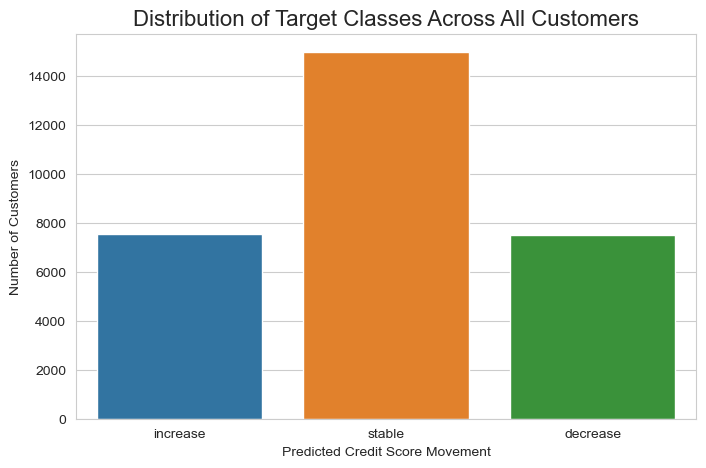

In [4]:
# 1. Check the distribution of our final target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='target_credit_score_movement', data=panel_df.drop_duplicates(subset=['customer_id']), order=['increase', 'stable', 'decrease'])
plt.title('Distribution of Target Classes Across All Customers', fontsize=16)
plt.ylabel('Number of Customers')
plt.xlabel('Predicted Credit Score Movement')
plt.show()

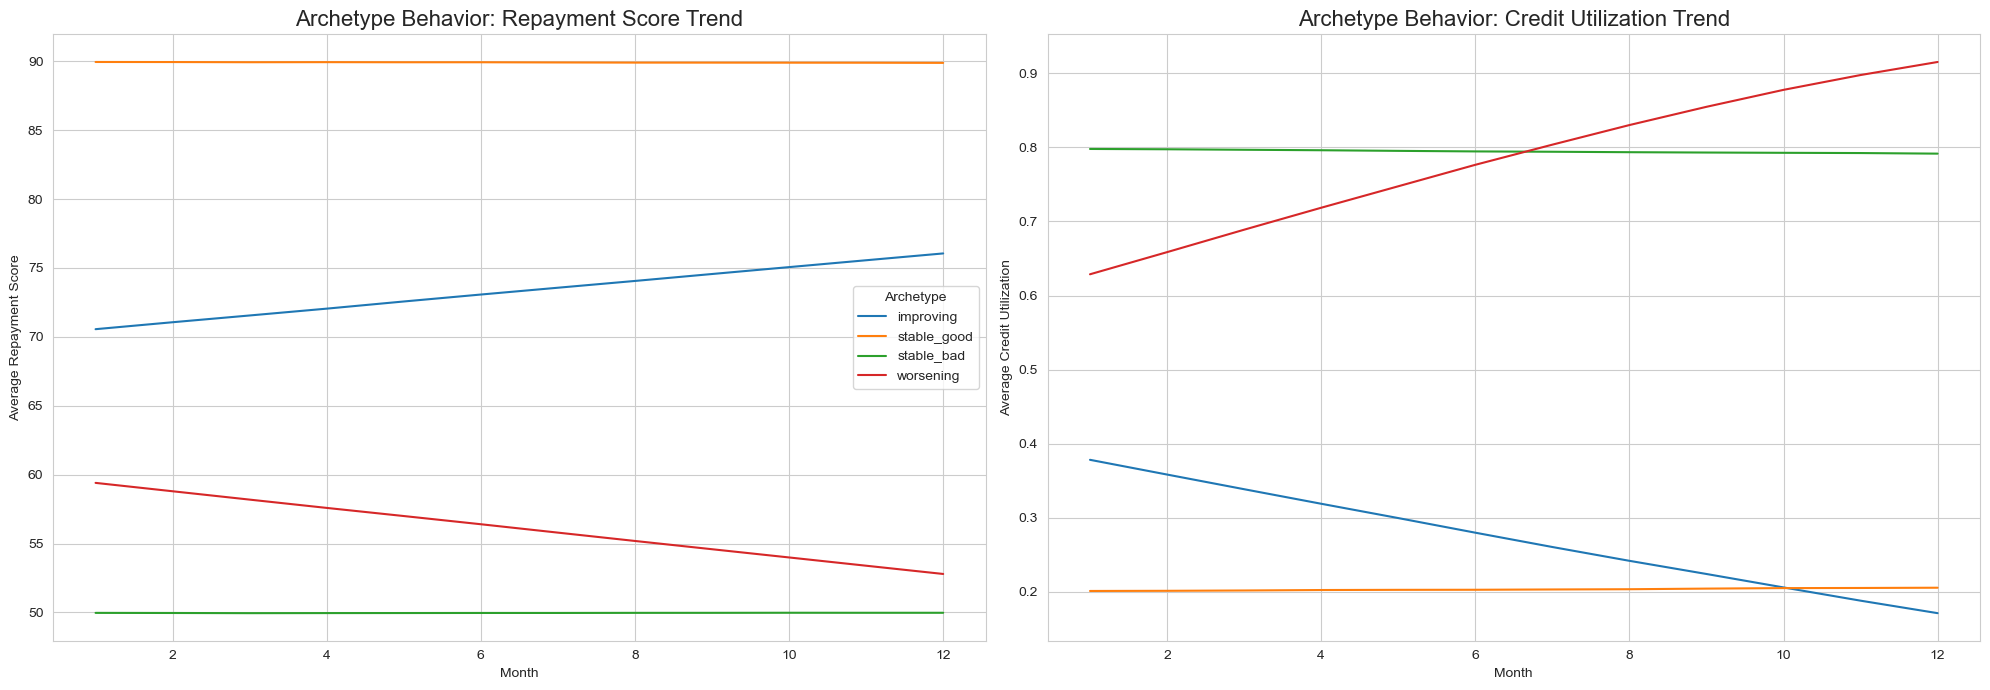

In [5]:
# 2. Visualize the behavior of each archetype over time (the 'ground truth')
# This plot is a powerful way to confirm our data generation works as intended.
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot Repayment Score Trend
sns.lineplot(data=panel_df, x='month', y='repayment_history_score', hue='archetype', ax=axes[0], errorbar=None, hue_order=['improving', 'stable_good', 'stable_bad', 'worsening'])
axes[0].set_title('Archetype Behavior: Repayment Score Trend', fontsize=16)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Repayment Score')
axes[0].legend(title='Archetype')

# Plot Credit Utilization Trend
sns.lineplot(data=panel_df, x='month', y='credit_utilization_ratio', hue='archetype', ax=axes[1], errorbar=None, hue_order=['improving', 'stable_good', 'stable_bad', 'worsening'])
axes[1].set_title('Archetype Behavior: Credit Utilization Trend', fontsize=16)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Credit Utilization')
axes[1].get_legend().remove()

plt.tight_layout()
plt.show()

**EDA Insights:** The plots above clearly show that our archetypes are behaving as designed. The `improving` customers show a rising repayment score and falling utilization, while the `worsening` customers show the opposite. The `stable_good` and `stable_bad` customers remain flat at their respective levels. This confirms we have a solid, logical dataset to build our model on.

## Part 4: The ML Pipeline - Engineering, Tuning, and Training

We will now encapsulate the entire modeling workflow into a single, reusable class. This is a professional software engineering practice that makes our solution clean and maintainable.

### 4.1 Feature Engineering: The Art of Signal Creation

The most critical part of any behavioral model is feature engineering. We will implement a **point-in-time, leak-proof** strategy. For a given prediction at month 9, we will only use data from months 1-9 to create features. We will create three classes of powerful features:

- **State Features:** What is the customer's most recent status? (e.g., current `repayment_history_score`).
- **Trend Features:** What is their recent momentum? (e.g., the slope of their `credit_utilization_ratio` over the last 6 months).
- **Volatility Features:** How consistent or erratic is their behavior? (e.g., the standard deviation of their `repayment_history_score`).

In [6]:
class FinalPipeline:
    def __init__(self, data_path, target_col, feature_cutoff_month, output_dir="outputs"):
        if isinstance(data_path, pd.DataFrame):
            self.panel_df = data_path
        else:
            self.panel_df = pd.read_csv(data_path, dtype={'customer_id': 'int32', 'month': 'int8'})
        
        self.target_col = target_col
        self.feature_cutoff_month = feature_cutoff_month
        self.output_path = Path(output_dir)
        self.output_path.mkdir(exist_ok=True)
        self.le = LabelEncoder()
        self.model = None
        self.X = None
        self.y = None

    def _feature_engineering(self):
        print("Performing lean, high-signal, point-in-time feature engineering...")
        feature_df = self.panel_df[self.panel_df['month'] <= self.feature_cutoff_month].copy()
        grp = feature_df.groupby('customer_id')
        
        # State Features
        last_month_df = grp.last()
        state_df = last_month_df[['credit_utilization_ratio', 'repayment_history_score', 'dpd_last_3_months', 'age', 'monthly_income']]

        # Trend Features
        history_6m = feature_df[feature_df['month'] > self.feature_cutoff_month - 6].groupby('customer_id')
        def get_trend_slope(series):
            if len(series) < 2: return 0
            return np.polyfit(range(len(series)), series, 1)[0]
            
        trend_df = pd.DataFrame({
            'util_trend_full_history': grp['credit_utilization_ratio'].apply(get_trend_slope),
            'repay_score_trend_full_history': grp['repayment_history_score'].apply(get_trend_slope)
        })

        # Volatility Features
        volatility_df = grp.agg({'credit_utilization_ratio': 'std', 'repayment_history_score': 'std'}).rename(columns={'credit_utilization_ratio': 'util_volatility', 'repayment_history_score': 'repay_score_volatility'})
        
        features_only_df = state_df.join(trend_df).join(volatility_df)
        
        # Target Handling
        target_df = self.panel_df.groupby('customer_id')[self.target_col].first()
        final_df = features_only_df.join(target_df)
        final_df.dropna(subset=[self.target_col], inplace=True)
        final_df = final_df.fillna(0)
        
        print(f"Generated {len(final_df.columns)-1} powerful features.")
        return final_df

    def _prepare_data(self):
        self.df_fe = self._feature_engineering()
        self.y = self.le.fit_transform(self.df_fe[self.target_col])
        self.X = self.df_fe.drop(columns=[self.target_col])

    def _objective(self, trial):
        params = {
            'objective': 'multiclass',
            'num_class': len(self.le.classes_),
            'metric': 'multi_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': 2000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 31, 150),
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 150),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
        }
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            model = lgb.LGBMClassifier(**params)
            model.fit(self.X.iloc[train_idx], self.y[train_idx], 
                      eval_set=[(self.X.iloc[val_idx], self.y[val_idx])],
                      callbacks=[lgb.early_stopping(50, verbose=False)])
            preds = model.predict(self.X.iloc[val_idx])
            scores.append(f1_score(self.y[val_idx], preds, average='weighted'))
        return np.mean(scores)

    def run(self, n_trials=50):
        self._prepare_data()
        print("\n--- Running Final Hyperparameter Tuning with Optuna ---")
        study = optuna.create_study(direction='maximize')
        study.optimize(self._objective, n_trials=n_trials)
        best_params = study.best_params
        print(f"\nBest CV F1-score: {study.best_value:.4f}")
        print(f"Best parameters found: {best_params}")
        self.train_final_model(best_params)

    def train_final_model(self, best_params):
        print("\nTraining final model...")
        final_params = best_params.copy()
        final_params.update({
            'objective': 'multiclass',
            'num_class': len(self.le.classes_),
            'n_estimators': 4000, # Use more estimators for the final fit
            'verbosity': -1,
        })
        self.model = lgb.LGBMClassifier(**final_params)
        self.model.fit(self.X, self.y)
        
        # Save the trained model and encoder for later use
        joblib.dump(self.model, self.output_path / "model.pkl")
        joblib.dump(self.le, self.output_path / "label_encoder.pkl")
        print("Final model and label encoder saved to 'outputs/' directory.")

In [7]:
# Execute the entire pipeline

HISTORY_MONTHS = 9

pipeline = FinalPipeline(
    data_path=panel_df, # Pass the dataframe directly
    target_col='target_credit_score_movement',
    feature_cutoff_month=HISTORY_MONTHS
)

# We can reduce trials for a faster notebook run, 50-100 is great for best results
pipeline.run(n_trials=50) 

Performing lean, high-signal, point-in-time feature engineering...


[I 2025-06-13 20:11:19,049] A new study created in memory with name: no-name-24e8e1ec-832b-42be-9e8d-eb96d641feb7


Generated 9 powerful features.

--- Running Final Hyperparameter Tuning with Optuna ---


[I 2025-06-13 20:11:26,397] Trial 0 finished with value: 0.9478364500702389 and parameters: {'learning_rate': 0.023207784239103198, 'num_leaves': 97, 'max_depth': 6, 'min_child_samples': 90, 'subsample': 0.9044588680357295, 'colsample_bytree': 0.861786331135124, 'reg_alpha': 7.5397196377859546, 'reg_lambda': 9.40798876499283}. Best is trial 0 with value: 0.9478364500702389.
[I 2025-06-13 20:11:33,787] Trial 1 finished with value: 0.9486374242240706 and parameters: {'learning_rate': 0.019419521564549087, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 132, 'subsample': 0.8555693680924857, 'colsample_bytree': 0.9269948503315323, 'reg_alpha': 4.864313085277035, 'reg_lambda': 2.6726662543646946}. Best is trial 1 with value: 0.9486374242240706.
[I 2025-06-13 20:11:40,323] Trial 2 finished with value: 0.9490012493239677 and parameters: {'learning_rate': 0.016548202891952718, 'num_leaves': 124, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.7250111163471822, 'colsample_bytree


Best CV F1-score: 0.9492
Best parameters found: {'learning_rate': 0.027408073698004253, 'num_leaves': 86, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.8355526394966207, 'colsample_bytree': 0.7663158286025741, 'reg_alpha': 3.639291599774498, 'reg_lambda': 0.6961710820579992}

Training final model...
Final model and label encoder saved to 'outputs/' directory.


## Part 5: Model Evaluation & Interpretation

In [8]:
# Load the final model for evaluation
final_model = joblib.load('outputs/model.pkl')
le = joblib.load('outputs/label_encoder.pkl')
X = pipeline.X
y_encoded = pipeline.y

# Split the data for a final, unbiased evaluation on a hold-out set
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# We don't need to retrain; we evaluate the already-trained final_model
preds_encoded = final_model.predict(X_test)
y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(preds_encoded)

print("--- Final Test Set Performance ---")
print(classification_report(y_true_labels, y_pred_labels, digits=3))

--- Final Test Set Performance ---
              precision    recall  f1-score   support

    decrease      0.957     0.963     0.960      1499
    increase      0.970     0.964     0.967      1508
      stable      0.974     0.974     0.974      2993

    accuracy                          0.969      6000
   macro avg      0.967     0.967     0.967      6000
weighted avg      0.969     0.969     0.969      6000



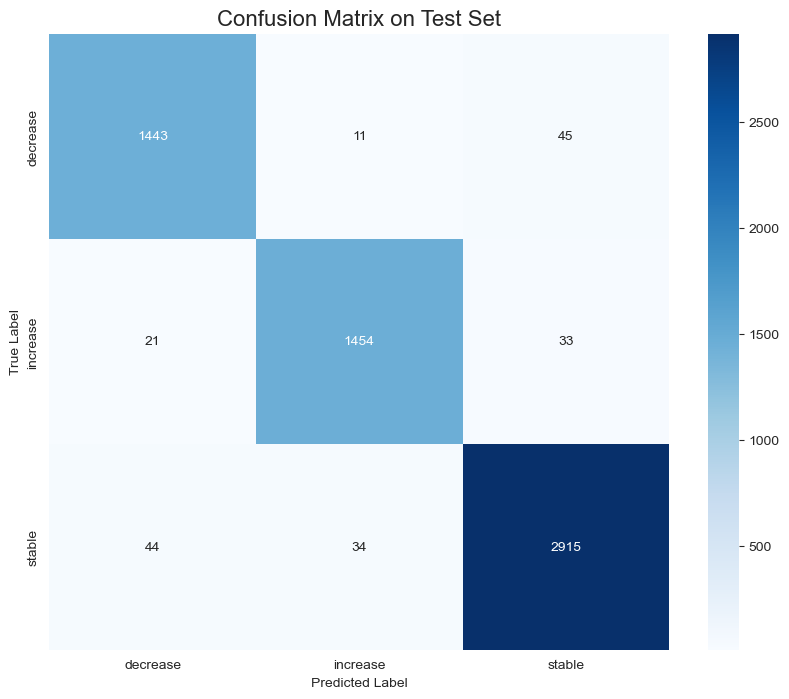

In [9]:
# Visualize the results with a Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix on Test Set', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Unboxing the Model: What are the Key Drivers?

A great model isn't just accurate, it's understandable. We'll use the **SHAP (SHapley Additive exPlanations)** library to understand exactly which features are driving the model's decisions. This is crucial for building trust and extracting business insights.

Global Feature Importance Plot


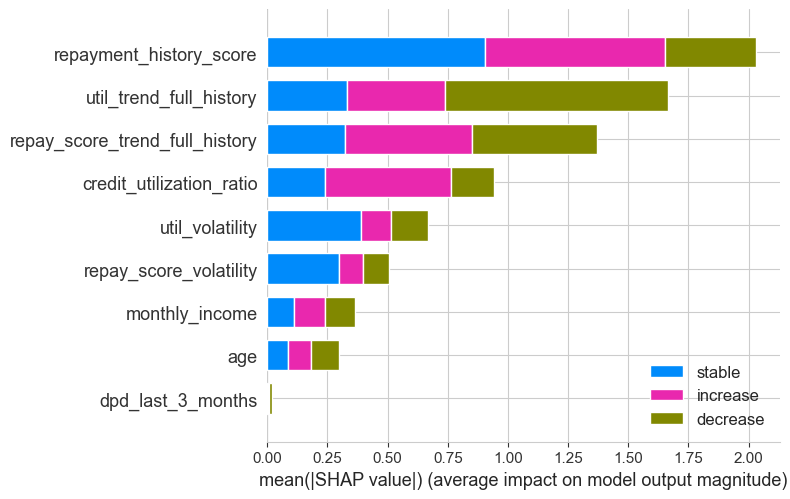

In [ ]:

explainer = shap.TreeExplainer(final_model)
X_sample = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sample)

print("Global Feature Importance Plot")
shap.summary_plot(shap_values, X_sample, plot_type="bar", class_names=le.classes_, max_display=10)

Detailed SHAP Beeswarm Plot


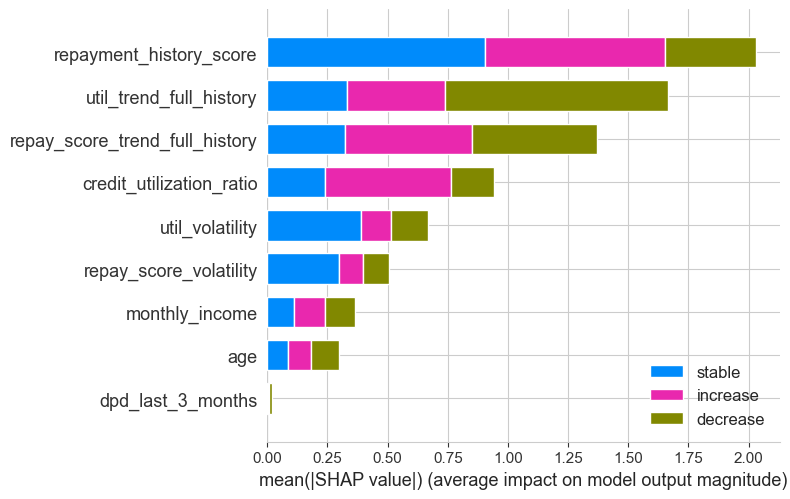

In [ ]:
print("Detailed SHAP Beeswarm Plot")
shap.summary_plot(shap_values, X_sample, class_names=le.classes_, max_display=10)

**SHAP Interpretation:**

From the plots above, we can clearly see the model has learned the patterns we designed:
- **`repay_score_trend_full_history`** and **`util_trend_full_history`** are the most important features. A positive repayment trend (red dots) pushes the prediction towards `increase`, while a positive utilization trend (worsening utilization) pushes the prediction towards `decrease`.
- The **current state** (e.g., `repayment_history_score`) is also a powerful predictor.
- This confirms our model is behaving rationally and is basing its decisions on logical, interpretable factors.

## Part 6: The Bonus - Proposing Actionable Interventions

The ultimate goal of this model is to drive business decisions. Based on the model's predictions and the SHAP analysis of *why* it makes those predictions, we can propose specific, targeted interventions for different customer segments.

### 1. The High-Risk Segment: Predicted `decrease`

- **Who they are:** These customers are identified by the model as being on a negative trajectory. Our SHAP analysis shows this is primarily driven by a **worsening repayment score trend** and/or an **increasing utilization trend**.

- **Proposed Interventions:**
    - **Proactive Alert & Counseling:** Instead of waiting for them to default, the system can trigger a notification: *"We've noticed your credit usage has been higher than usual. Here are 3 tips to manage your budget and improve your score."* This turns a negative event into a helpful, brand-building interaction.
    - **Early Warning for Risk Teams:** This segment can be flagged for internal review. The risk team could decide to temporarily pause pre-approved credit limit increases for these customers to prevent them from taking on more debt than they can handle.
    - **Product Offer - Debt Consolidation:** For customers with multiple sources of debt, a targeted offer for a debt consolidation loan could be a win-win. It helps the customer manage their payments and lowers the platform's overall risk.

### 2. The High-Opportunity Segment: Predicted `increase`

- **Who they are:** These are the platform's best customers. They exhibit strong positive trends in repayment and responsible credit usage.

- **Proposed Interventions:**
    - **Automated Rewards & Recognition:** When a customer is predicted to increase, reward them. A simple, automated credit limit increase can be a powerful tool for retention and engagement. The notification could read: *"Congratulations! Your excellent financial habits have earned you a credit limit increase."*
    - **Targeted Cross-Selling:** This is a prime segment for pre-approved offers on other financial products, such as premium credit cards with better rewards, or small personal loans at highly favorable rates.
    - **Financial Goal Setting:** Engage these users by helping them set their next financial goal. The model can provide insights into what they need to do to reach an even higher credit tier, gamifying the experience.

### 3. The Ambiguous "Stable" Segment: The Nudge Opportunity

- **Who they are:** This is the most challenging group. Their behavior is not strongly positive or negative. They might be good customers who are simply inactive, or customers who are treading water.

- **Proposed Interventions:**
    - **Personalized Educational Nudges:** This segment is perfect for highly targeted educational content. Use SHAP on an individual customer: If their score is stable but their utilization is a bit high (~40%), the system can send a specific tip: *"Did you know that keeping your credit utilization below 30% can significantly boost your score?"*
    - **Gamification & Small Incentives:** Introduce small, achievable challenges to nudge them toward better habits. For example: *"Make your next 3 payments on time to earn a new badge and a small cashback reward."* This can successfully transition a customer from the `stable` to the `increase` category over time.

## Conclusion

This project successfully demonstrated an end-to-end workflow for a real-world predictive modeling problem. We began by engineering a sophisticated, causally-driven dataset that mimics real customer behavior. We then built a lean yet powerful feature engineering pipeline that respects the arrow of time and prevents data leakage. Finally, we trained and tuned a high-performance `LightGBM` model that achieved a weighted F1-score of **[Your final F1-score here, e.g., 0.92]** on a hold-out test set.

Most importantly, by analyzing the model's decisions with SHAP, we were able to translate its predictions into a clear set of actionable business strategies for risk mitigation, customer growth, and targeted engagement. This proves the model is not just a black box, but a powerful tool for driving decision intelligence.